<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
#Проверим в хронологическом порядке ли индекс
print('Данные в хронологическом порядке?',df.index.is_monotonic)

Данные в хронологическом порядке? True


In [6]:
#Ресемплируем данные по одному часу
df = df.resample('1H').sum()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [7]:
data = df.resample('1D').sum()

decomposed = seasonal_decompose(data['num_orders'])

Text(0, 0.5, 'Значения ряда')

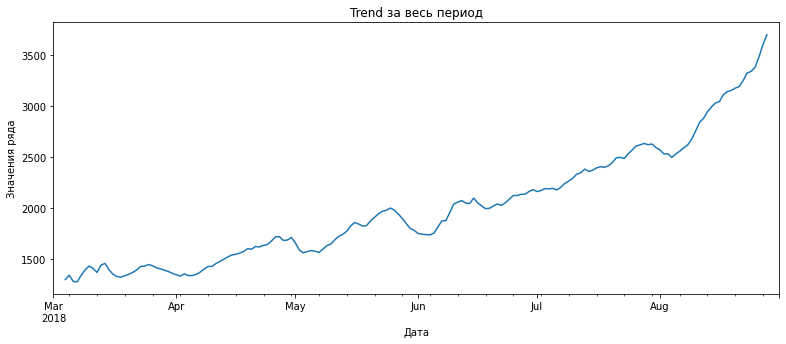

In [8]:
plt.figure(figsize=(13, 5))
plt.subplot(111)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend за весь период')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

Text(0, 0.5, 'Значения ряда')

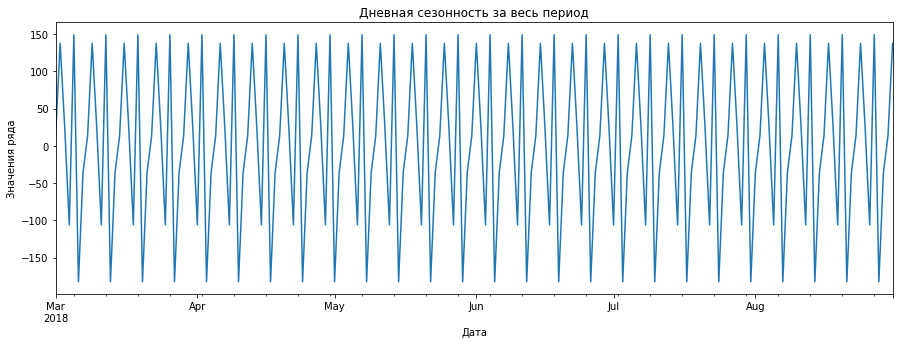

In [9]:
data = df.resample('1D').sum()

decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15, 5))
plt.subplot(111)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Дневная сезонность за весь период')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

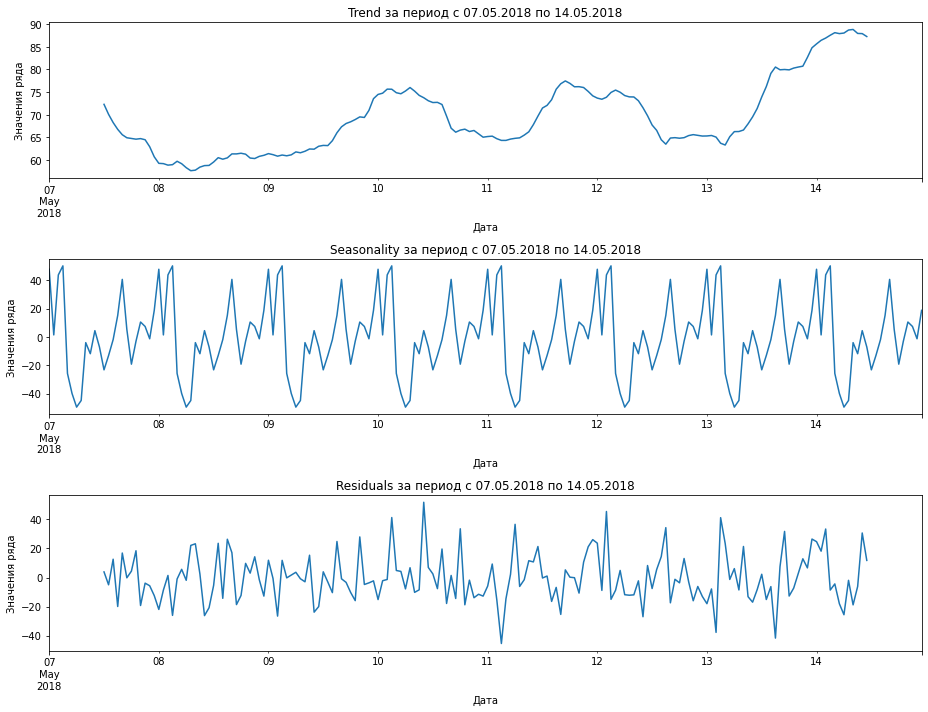

In [10]:
data = df['2018-05-7':'2018-05-14'].resample('1H').sum()

decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(13, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend за период с 07.05.2018 по 14.05.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality за период с 07.05.2018 по 14.05.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals за период с 07.05.2018 по 14.05.2018')
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Значения ряда', fontsize=10)

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

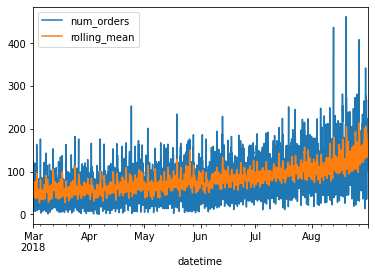

In [11]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot()

**Вывод**

Исходя из графиков наблюдается положительный рост. Также видна ярковыраженная еженедельная сезонность, с пиком в середине недели и с воскресенья на понедельник. Высокий спрос в течении дня приобладает в вечернее время.

## Обучение

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    features_train = train.drop('num_orders',axis=1)
    features_test = test.drop('num_orders',axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']


In [13]:
# посмотрим на таблицу с новыми признаками
make_features(df, 6, 7)
df.head(15)

,num_orders,rolling_mean,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,1,0,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,1,2,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,1,4,3,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 05:00:00,6,NaN,3,1,5,3,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 06:00:00,12,NaN,3,1,6,3,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 07:00:00,15,58.142857,3,1,7,3,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-01 08:00:00,34,42.571429,3,1,8,3,15.0,12.0,6.0,43.0,66.0,71.0


In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
    
features_train = train.drop('num_orders',axis=1)
features_test = test.drop('num_orders',axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [15]:
print('Кол-во строк в обучающей выборке:', features_train.shape[0])
print('Кол-во строк в тестовой выборке:', features_test.shape[0])

Кол-во строк в обучающей выборке: 3967
Кол-во строк в тестовой выборке: 442


**DecisionTreeRegressor**

In [16]:
%%time
model_dt= DecisionTreeRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(20,30)
}
gsearch = GridSearchCV(model_dt, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
dt_model = gsearch.fit(features_train,target_train)
rmse_model_dt = -dt_model.best_score_
print(f'Лучшая RMSE: {rmse_model_dt} при параметрах {dt_model.best_params_}')

Лучшая RMSE: 27.569379208404776 при параметрах {'max_depth': 15, 'min_samples_leaf': 21}
CPU times: user 661 ms, sys: 0 ns, total: 661 ms
Wall time: 683 ms


In [17]:
index_table = 0
table = pd.DataFrame(columns=['name','rmse'])
index_table +=1
table.loc[index_table] = ['DecisionTreeRegressor', rmse_model_dt]
table

,name,rmse
1,DecisionTreeRegressor,27.569379


**LinearRegression**

In [18]:
%%time
model_lr = LinearRegression() 
model_lr.fit(features_train, target_train)
 
predictions = model_lr.predict(features_train)
rmse_model_linReg = mse(target_train,predictions,squared= False)
print("RMSE:", rmse_model_linReg)

RMSE: 30.42207274788726
CPU times: user 19.9 ms, sys: 2.08 ms, total: 22 ms
Wall time: 15.9 ms


In [19]:
index_table +=1
table.loc[index_table] = ['Linear Regression', rmse_model_linReg]
table

,name,rmse
1,DecisionTreeRegressor,27.569379
2,Linear Regression,30.422073


**RandomForestRegressor**

In [20]:
%%time

model_rf= RandomForestRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(2,3)
}
gsearch = GridSearchCV(model_rf, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
rf_model = gsearch.fit(features_train,target_train)
rmse_model_RandForest = -rf_model.best_score_
print(f'Лучшая RMSE: {rmse_model_RandForest} при параметрах ,{rf_model.best_params_}')

Лучшая RMSE: 25.309593257264822 при параметрах ,{'max_depth': 15, 'min_samples_leaf': 2}
CPU times: user 6.34 s, sys: 28.7 ms, total: 6.37 s
Wall time: 6.37 s


In [21]:
index_table +=1
table.loc[index_table] = ['Random Forest', rmse_model_RandForest]
table

,name,rmse
1,DecisionTreeRegressor,27.569379
2,Linear Regression,30.422073
3,Random Forest,25.309593


**CatBoostRegressor**

Можно перевести в код, но долго выполняется.

In [22]:
%%time
model_cat = CatBoostRegressor(loss_function="RMSE", depth=5,\
                              l2_leaf_reg=30, learning_rate=0.1,\
                              iterations=10000
                             )
model_cat.fit(features_train, target_train, verbose=100);

0:	learn: 37.1825167	total: 50ms	remaining: 8m 19s
100:	learn: 23.8775733	total: 233ms	remaining: 22.8s
200:	learn: 23.3812782	total: 425ms	remaining: 20.7s
300:	learn: 21.9240165	total: 573ms	remaining: 18.5s
400:	learn: 20.8047978	total: 721ms	remaining: 17.3s
500:	learn: 19.8295052	total: 868ms	remaining: 16.5s
600:	learn: 18.7343935	total: 1.03s	remaining: 16.1s
700:	learn: 17.9223333	total: 1.21s	remaining: 16.1s
800:	learn: 17.3634518	total: 1.36s	remaining: 15.6s
900:	learn: 16.7898539	total: 1.51s	remaining: 15.3s
1000:	learn: 16.2409365	total: 1.66s	remaining: 14.9s
1100:	learn: 15.8588742	total: 1.82s	remaining: 14.7s
1200:	learn: 15.4984914	total: 1.99s	remaining: 14.5s
1300:	learn: 15.1110138	total: 2.13s	remaining: 14.3s
1400:	learn: 14.7464511	total: 2.29s	remaining: 14s
1500:	learn: 14.4502753	total: 2.44s	remaining: 13.8s
1600:	learn: 14.0512955	total: 2.59s	remaining: 13.6s
1700:	learn: 13.7152008	total: 2.75s	remaining: 13.4s
1800:	learn: 13.4045506	total: 2.9s	remain

In [23]:
predict_model = model_cat.predict(features_test, verbose=0)
rmse_model_cat = mse(target_test, predict_model)**(0.5)
print('rmse =', rmse_model_cat)

rmse = 48.761307869110524


In [24]:
index_table +=1
table.loc[index_table] = ['CatBoost', rmse_model_cat]
table

,name,rmse
1,DecisionTreeRegressor,27.569379
2,Linear Regression,30.422073
3,Random Forest,25.309593
4,CatBoost,48.761308


In [25]:
RSME_dt = -cross_val_score(model_dt, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
RSME_rf = -cross_val_score(model_rf, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
RSME_lr = -cross_val_score(model_lr, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
RSME_cat = -cross_val_score(model_cat, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
print("RMSE_dt:", RSME_dt)
print("RMSE_rf:", RSME_rf)
print("RMSE_lr:", RSME_lr)
print("RMSE_cat:", RSME_cat)

0:	learn: 28.4152799	total: 869us	remaining: 8.7s
1:	learn: 27.6464546	total: 2.1ms	remaining: 10.5s
2:	learn: 26.8786020	total: 3.07ms	remaining: 10.2s
3:	learn: 26.2220296	total: 3.91ms	remaining: 9.77s
4:	learn: 25.5470004	total: 4.7ms	remaining: 9.4s
5:	learn: 24.9359627	total: 5.64ms	remaining: 9.39s
6:	learn: 24.5048559	total: 6.58ms	remaining: 9.39s
7:	learn: 24.0917996	total: 7.49ms	remaining: 9.36s
8:	learn: 23.6030061	total: 8.42ms	remaining: 9.35s
9:	learn: 23.2086411	total: 9.28ms	remaining: 9.27s
10:	learn: 22.8047085	total: 10.1ms	remaining: 9.14s
11:	learn: 22.4431628	total: 10.8ms	remaining: 9.03s
12:	learn: 22.0957122	total: 11.7ms	remaining: 8.99s
13:	learn: 21.7707417	total: 12.5ms	remaining: 8.9s
14:	learn: 21.5045643	total: 13.3ms	remaining: 8.88s
15:	learn: 21.3012030	total: 14.2ms	remaining: 8.85s
16:	learn: 21.1472933	total: 15ms	remaining: 8.83s
17:	learn: 20.9748861	total: 15.8ms	remaining: 8.76s
18:	learn: 20.8004640	total: 16.7ms	remaining: 8.75s
19:	learn: 

## Тестирование

In [26]:
#Результат сравнения на кросс-валидации для всех моделей
print("RMSE_dt:", RSME_dt)
print("RMSE_rf:", RSME_rf)
print("RMSE_lr:", RSME_lr)
print("RMSE_cat:", RSME_cat)

RMSE_dt: 33.025490860151244
RMSE_rf: 25.275076044714808
RMSE_lr: 31.588085828396657
RMSE_cat: 26.300891833020575


Основываясь на результатах кросс-валидации лучший результат показала модель RandomForestRegressor

In [27]:
%%time
model_rf = (RandomForestRegressor(max_depth=15,
                                 random_state=12345,
                                  min_samples_leaf=2
                                )
           .fit(features_train, target_train)
          )

predictions_test = model_rf.predict(features_test)
mse_test = mse(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

CPU times: user 366 ms, sys: 0 ns, total: 366 ms
Wall time: 365 ms


46.63352015707986

**ВЫВОД**

В ходе проекта были обработаны данные о заказах такси. Для прогноза количества заказов такси были построены 4 модели предскания. Основываясь на результатах кросс-валидации лучший результат показала модель RandomForestRegressor (25) 


Результат проверки на тестовой выборке для модели RandomForestRegressor = 46 (что подходит к нашим условиям)